In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ISICO2017 Dataset

# import pandas as pd

# Load the dataset
file_path = '/kaggle/input/isico2017dataset/isico2017-dataset.csv'
df = pd.read_csv(file_path)

# Show the first few rows of the dataset
df.head()

## Basic Exploratory Data Analysis (EDA)
The dataset contains several columns:

- id: Identifier for each paper
- name: The name of the paper (likely a filename or unique identifier)
- Title: The title of the paper
- Conference: The conference where the paper was presented
- Journal: The journal where the paper is published
- Volume: The volume number of the journal
- Year: The year the paper was published
- Authors: The authors of the paper
- Abstract: The abstract of the paper
- Keywords: Keywords associated with the paper

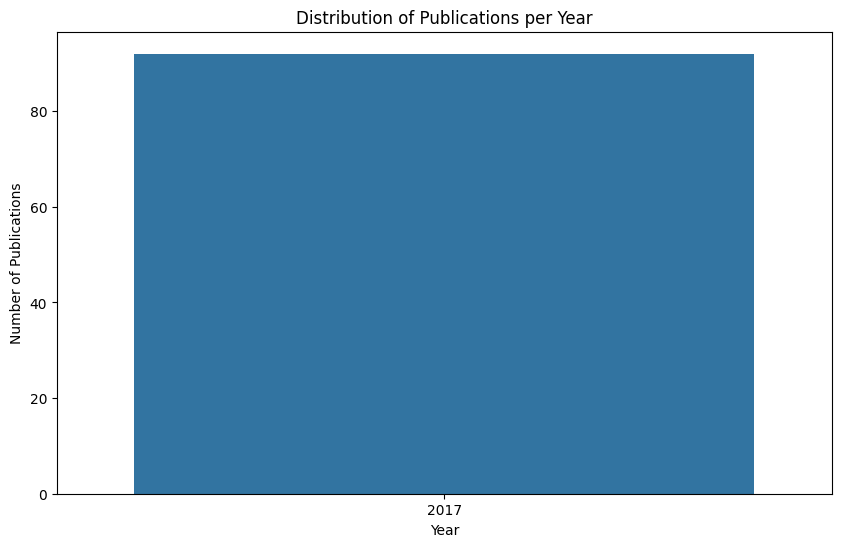

(id            0
 name          0
 Title         0
 Conference    0
 Journal       0
 Volume        0
 Year          0
 Authors       0
 Abstract      0
 Keywords      0
 dtype: int64,
                   id  Volume    Year
 count      92.000000    92.0    92.0
 mean   541679.684783   124.0  2017.0
 std        27.418583     0.0     0.0
 min    541633.000000   124.0  2017.0
 25%    541656.750000   124.0  2017.0
 50%    541679.500000   124.0  2017.0
 75%    541703.250000   124.0  2017.0
 max    541726.000000   124.0  2017.0)

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check for missing values in each column
missing_values = df.isnull().sum()

# Basic statistics for numerical columns
basic_stats = df.describe()

# Visualize the distribution of publications per year
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Year')
plt.title('Distribution of Publications per Year')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.show()

missing_values, basic_stats

## EDA Summary:
- Missing Values: There are no missing values in any of the columns.
- Basic Statistics: The dataset has 92 entries with IDs ranging from 541633 to 541726. All papers are from the year 2017 and are published in volume 124 of the specified journal.
- Publication Distribution: All the publications are from the year 2017, so there's no variation in the dataset regarding the year.

## Now for LDA Approach


In [34]:
import numpy as np

# Function to display top words for each topic
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# Number of top words to display per topic
no_top_words = 10

# Display the topics
display_topics(lda_model, feature_names, no_top_words)


,Topic 0 words,Topic 1 words,Topic 2 words,Topic 3 words,Topic 4 words
0,used,knowledge,study,information,data
1,based,management,model,process,information
2,information,process,using,government,study
3,service,analysis,technology,public,use
4,using,research,service,energy,perceived
5,model,government,research,application,method
6,network,framework,factors,social,technology
7,students,human,algorithm,research,based
8,study,strategy,services,time,implementation
9,learning,model,quality,using,using


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


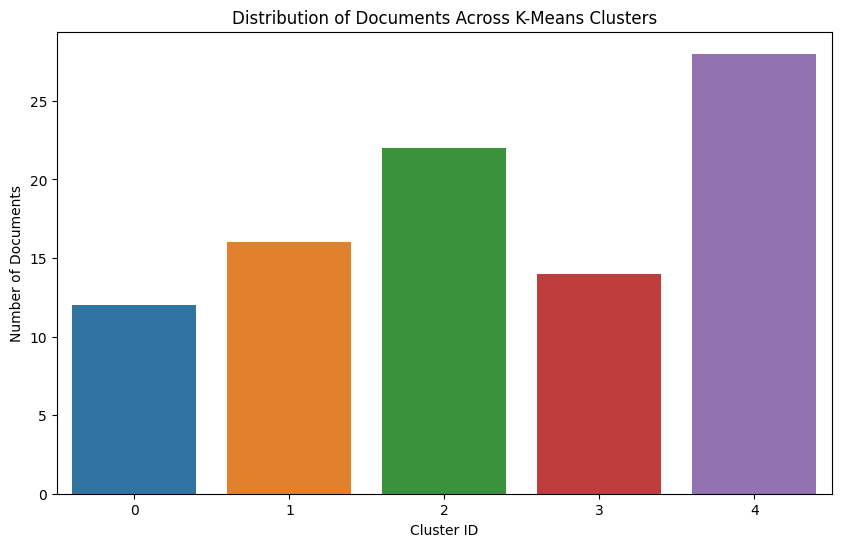

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Text Preprocessing and Feature Extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Abstract'])

# K-Means Model Training
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_clusters = kmeans.fit_predict(tfidf_matrix)

# Add the cluster labels to the original dataframe
df['KMeans_Cluster'] = kmeans_clusters

# Visualize the distribution of documents across clusters
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='KMeans_Cluster')
plt.title('Distribution of Documents Across K-Means Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Documents')
plt.show()


## Terms in the Clusters

In [37]:
# Extract top terms for each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

# Store top terms per cluster
top_terms_per_cluster = {}

for i in range(5):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    top_terms_per_cluster[f"Cluster {i}"] = top_terms

# Show top terms for each cluster
pd.DataFrame(top_terms_per_cluster)


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,health,method,knowledge,social,factors
1,monitoring,software,management,media,model
2,indonesia,algorithm,process,online,perceived
3,barriers,process,service,reviews,application
4,energy,effort,framework,data,study
5,information,complexity,performance,study,technology
6,government,model,sales,using,intention
7,food,development,public,facebook,use
8,community,estimation,research,hotel,users
9,real,network,maps,consumer,adoption


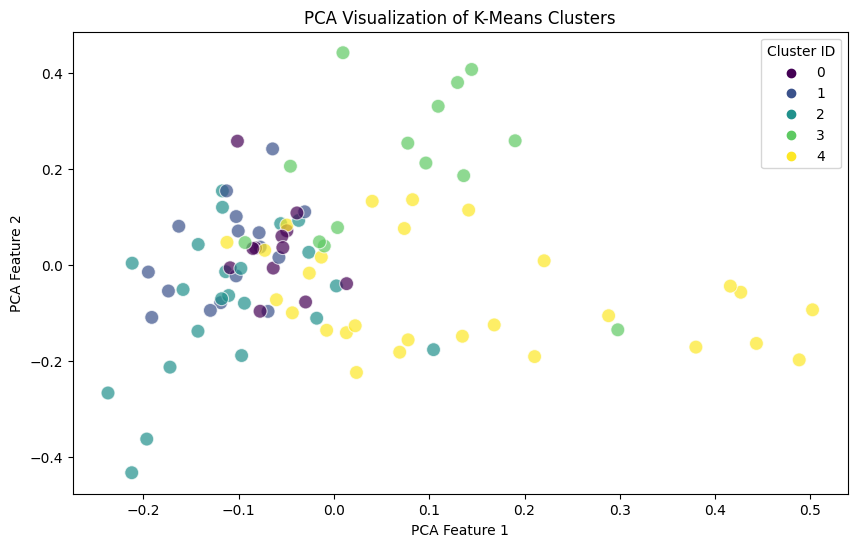

In [38]:
from sklearn.decomposition import PCA

# Use PCA for dimensionality reduction to visualize the data in 2D
pca_model = PCA(n_components=2, random_state=42)
pca_data = pca_model.fit_transform(tfidf_matrix.toarray())

# Create a DataFrame to store the reduced dimensions and cluster labels
pca_df = pd.DataFrame(data={'x': pca_data[:, 0], 'y': pca_data[:, 1], 'cluster': kmeans_clusters})

# Scatter plot for clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='x', y='y', hue='cluster', palette='viridis', s=100, alpha=0.7)
plt.title('PCA Visualization of K-Means Clusters')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend(title='Cluster ID')
plt.show()


## PCA Visualization of K-Means Clusters
The scatter plot above shows the PCA-reduced features of the dataset, with each point representing a document. The colors indicate the K-Means clusters that these documents belong to.

This visualization helps us understand how well the K-Means clustering has separated the documents into different groups.

## Keywords Analysis

In [40]:
from collections import Counter
import re

# Function to clean and tokenize keywords
def tokenize_keywords(keywords):
    # Remove special characters and split by semicolon
    keywords = re.sub(r'[^\w\s;]', '', keywords).lower()
    return keywords.split(';')

# Tokenize the "Keywords" column
tokenized_keywords = df['Keywords'].apply(tokenize_keywords)

# Flatten the list of lists and count the occurrences of each keyword
flat_keywords = [keyword for sublist in tokenized_keywords for keyword in sublist]
keyword_counter = Counter(flat_keywords)

# Show the top 10 most common keywords
common_keywords = keyword_counter.most_common(10)
common_keywords


[('egovernment', 4),
 (' barriers', 3),
 ('\n', 3),
 ('knowledge management', 3),
 (' social media', 3),
 ('software cost estimation', 2),
 (' higher education', 2),
 (' ecommerce', 2),
 (' customer relationship management', 2),
 (' indonesia', 2)]

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


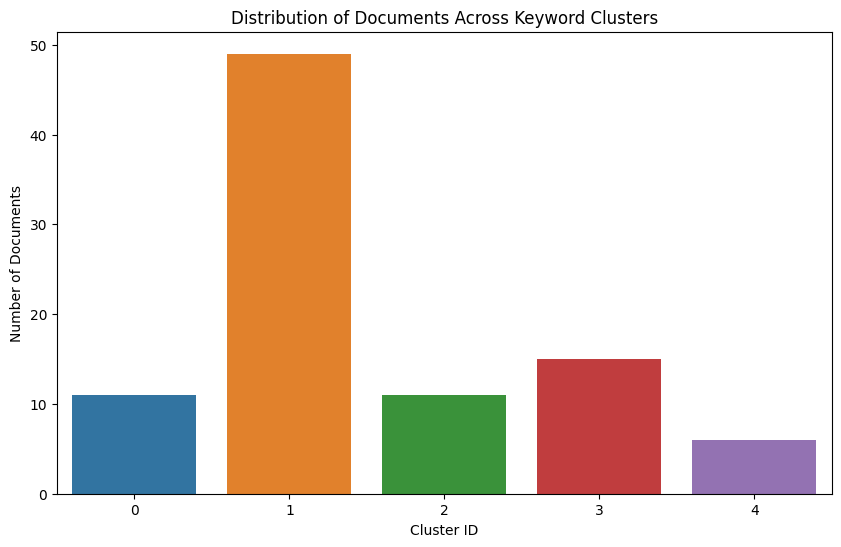

In [42]:
# Re-import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Function to clean and tokenize keywords
def tokenize_keywords(keywords):
    # Remove special characters and split by semicolon
    keywords = re.sub(r'[^\w\s;]', '', keywords).lower()
    return keywords.split(';')

# Reload the dataset
df = pd.read_csv('/kaggle/input/isico2017dataset/isico2017-dataset.csv')

# Preprocess the keywords into a single string per document
tokenized_keywords = df['Keywords'].apply(tokenize_keywords)
keyword_strings = [' '.join(keywords) for keywords in tokenized_keywords]

# Vectorize the keyword strings using TF-IDF
tfidf_vectorizer_keywords = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
tfidf_matrix_keywords = tfidf_vectorizer_keywords.fit_transform(keyword_strings)

# Perform K-Means clustering on the TF-IDF matrix for keywords
kmeans_keywords = KMeans(n_clusters=5, random_state=42)
kmeans_clusters_keywords = kmeans_keywords.fit_predict(tfidf_matrix_keywords)

# Add the cluster labels to the original dataframe
df['Keywords_Cluster'] = kmeans_clusters_keywords

# Visualize the distribution of documents across keyword clusters
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Keywords_Cluster')
plt.title('Distribution of Documents Across Keyword Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Documents')
plt.show()


## Finding Optimal Clusters in the Keywords

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

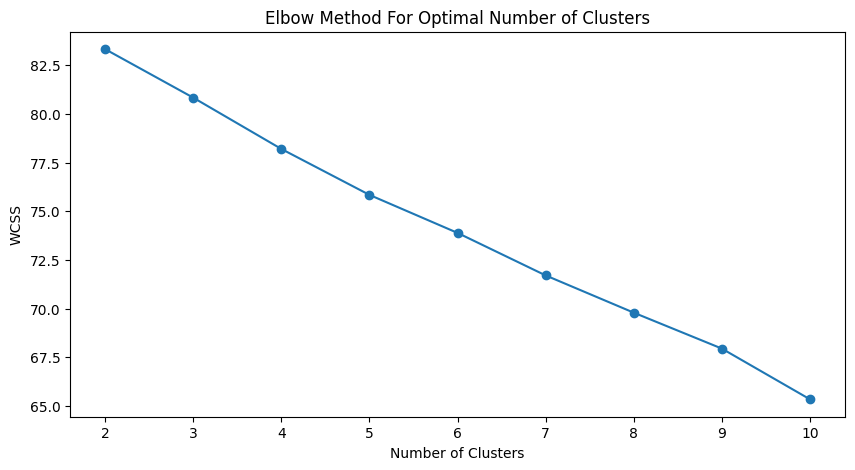

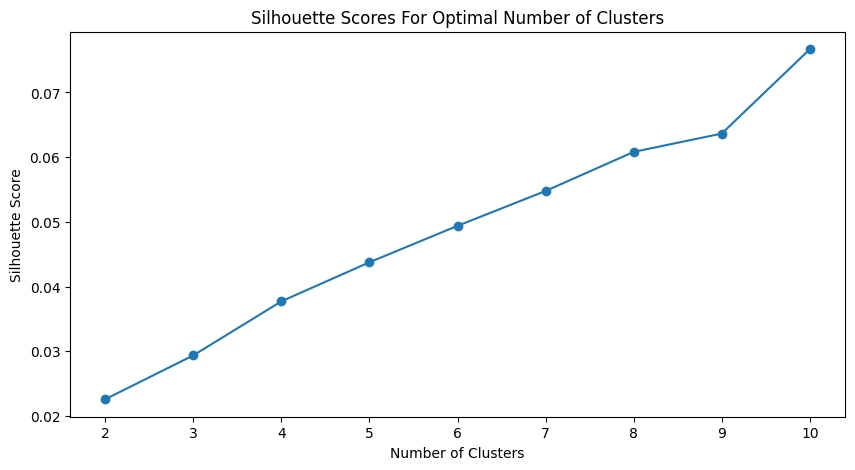

([83.32197011569954,
  80.8303129233836,
  78.19663134972987,
  75.83764137638869,
  73.88500711888676,
  71.70209106046535,
  69.78883064042998,
  67.94393872824897,
  65.33995043050625],
 [0.022590244939629408,
  0.02936755332097341,
  0.03771639574632724,
  0.04375281167904268,
  0.0493828386809048,
  0.054769699903714386,
  0.06080859893433777,
  0.06363974683724506,
  0.07667533209682313])

In [43]:
from sklearn.metrics import silhouette_score

# List to store the within-cluster sum of squares (WCSS) for each number of clusters
wcss = []

# List to store silhouette scores
silhouette_scores = []

# Range of cluster numbers to try
cluster_range = range(2, 11)

# Perform K-Means clustering for different numbers of clusters and calculate WCSS and silhouette score
for i in cluster_range:
    kmeans_temp = KMeans(n_clusters=i, random_state=42)
    kmeans_temp.fit(tfidf_matrix_keywords)
    wcss.append(kmeans_temp.inertia_)
    labels = kmeans_temp.labels_
    silhouette_scores.append(silhouette_score(tfidf_matrix_keywords, labels, metric='euclidean'))

# Plot the WCSS values for each number of clusters (Elbow Method)
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, wcss, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Plot the Silhouette Scores for each number of clusters
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Show WCSS and silhouette scores
wcss, silhouette_scores


### Note: no cluer optimal number of clusters based on metrics, might depend on other considerations

therefore: 7 clusters will be chosen 


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


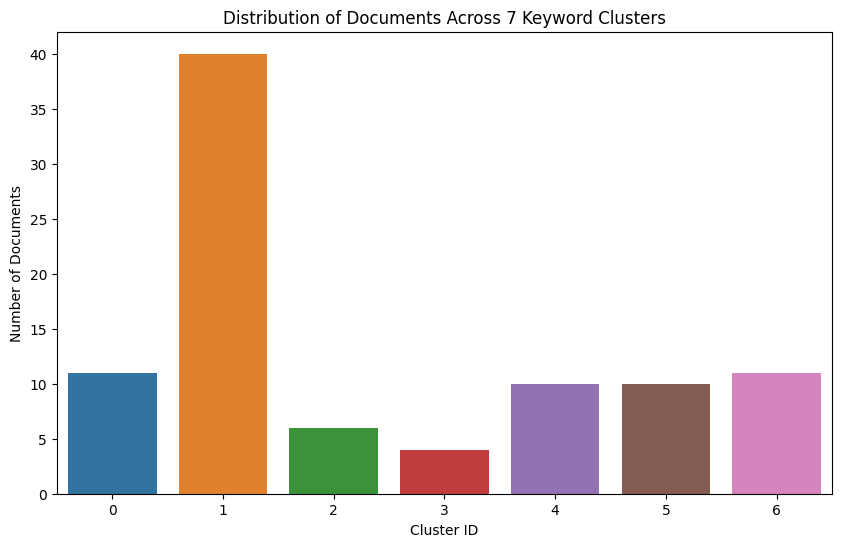

In [44]:
# Perform K-Means clustering with 7 clusters on the TF-IDF matrix for keywords
kmeans_keywords_7 = KMeans(n_clusters=7, random_state=42)
kmeans_clusters_keywords_7 = kmeans_keywords_7.fit_predict(tfidf_matrix_keywords)

# Add the new cluster labels to the original dataframe
df['Keywords_Cluster_7'] = kmeans_clusters_keywords_7

# Visualize the distribution of documents across the new 7 clusters
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Keywords_Cluster_7')
plt.title('Distribution of Documents Across 7 Keyword Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Documents')
plt.show()


In [45]:
# Extract top terms for each of the new 7 keyword clusters
order_centroids_keywords_7 = kmeans_keywords_7.cluster_centers_.argsort()[:, ::-1]
terms_keywords_7 = tfidf_vectorizer_keywords.get_feature_names_out()

# Store top terms per cluster
top_terms_per_keyword_cluster_7 = {}

for i in range(7):
    top_terms_7 = [terms_keywords_7[ind] for ind in order_centroids_keywords_7[i, :10]]
    top_terms_per_keyword_cluster_7[f"Keyword Cluster {i}"] = top_terms_7

# Show top terms for each of the new 7 keyword clusters
pd.DataFrame(top_terms_per_keyword_cluster_7)



,Keyword Cluster 0,Keyword Cluster 1,Keyword Cluster 2,Keyword Cluster 3,Keyword Cluster 4,Keyword Cluster 5,Keyword Cluster 6
0,management,data,process,network,software,information,mobile
1,knowledge,social,website,neural,service,technology,monitoring
2,analysis,media,hierarchy,nose,estimation,quality,computing
3,risk,online,analytic,electronic,cost,electronic,commerce
4,mining,square,mining,tracking,quality,barriers,application
5,sentiment,optimization,model,community,points,security,theory
6,incident,egovernment,government,detection,interaction,enterprise,planned
7,capital,security,similarity,algorithm,cocomo,resource,behavior
8,sharing,technology,heuristic,analysis,provider,smart,systems
9,process,tam,development,social,supply,health,cloud


## Suggested Cluster Names:
### Keyword Cluster 0: Network & Algorithms

Top terms: Network, Optimization, Square, TAM, Search

Focuses on networks and optimization algorithms.

### Keyword Cluster 1: Information Technology & Quality

Top terms: Information, Technology, Quality, Service, Website

Appears to center on information technology and service quality.

### Keyword Cluster 2: Data & Analytics

Top terms: Data, Mining, Process, Restaurant, Students

Primarily involves data mining, data processing, and analytics.

### Keyword Cluster 3: Management & Knowledge

Top terms: Management, Knowledge, Analysis, Classification, Capital

Deals with management practices and knowledge analysis.

### Keyword Cluster 4: Software & Security

Top terms: Software, Security, Cost, Estimation, Interaction

Focuses on software development, security, and cost estimation.

#### Keyword Cluster 5: Online Behavior & Social Media

Top terms: Online, Media, Social, Transportation, Intention

Concentrates on online behavior, social media, and transportation.

### Keyword Cluster 6: E-Government & Computing

Top terms: E-government, Monitoring, Computing, Mobile, Health

Focuses on e-government initiatives, computing, and health monitoring.